# Model Explainability and Insights Analysis

In [1]:
# Model Explainability and Insights Analysis

# Core data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model explainability
import shap

# Model loading and file handling
import joblib
import os
from pathlib import Path

# Display settings
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)



In [2]:
# Check if we need to change working directory
current_dir = os.getcwd()
target_dir = os.path.dirname(current_dir)  # Get parent directory

if current_dir.endswith('notebooks'):  # Only change if we're in notebooks directory
    os.chdir('..')
    print(f"Changed working directory from {current_dir} to {os.getcwd()}")
else:
    print(f"Working directory already set to {current_dir}")

os.makedirs('data', exist_ok=True)  
os.makedirs('models', exist_ok=True) 

Changed working directory from c:\Work\GIT\Fraud-Detection-in-Job-Postings-A-Comprehensive-ML-Pipeline-Tutorial\notebooks to c:\Work\GIT\Fraud-Detection-in-Job-Postings-A-Comprehensive-ML-Pipeline-Tutorial


### SHAP Analysis for Model Interpretability

#### Purpose:
- Analyzes and visualizes feature importance using SHAP (SHapley Additive exPlanations) values
- Provides insights into model decisions and feature interactions
- Quantifies the impact of each feature on model predictions

#### Components:

1. **Setup and Data Loading**:
   - Loads the trained model and test data
   - Sets up display options for better visualization
   - Prepares feature names for analysis

2. **ShapAnalyzer Class**:
   - Encapsulates SHAP analysis functionality
   - Methods for calculating SHAP values and creating visualizations
   - Handles both global and feature-specific analyses

3. **Analysis Operations**:
   - **Global Feature Importance**: Visualizes overall impact of features
   - **Feature Dependence**: Shows how specific features affect predictions
   - **Impact Analysis**: Quantifies positive and negative feature impacts
   - **Interaction Analysis**: Identifies important feature interactions

4. **Results Display**:
   - Top important features and their contribution percentages
   - Feature impact analysis (positive and negative)
   - Summary statistics
   - Feature interaction insights

#### Why It's Important:
- **Model Interpretability**: Helps understand how the model makes decisions
- **Feature Selection**: Identifies most influential features
- **Model Validation**: Ensures model behavior aligns with domain knowledge
- **Bias Detection**: Helps identify potential biases in model predictions

=== SHAP Analysis for Fraud Detection Model ===

Global Feature Importance Plot:


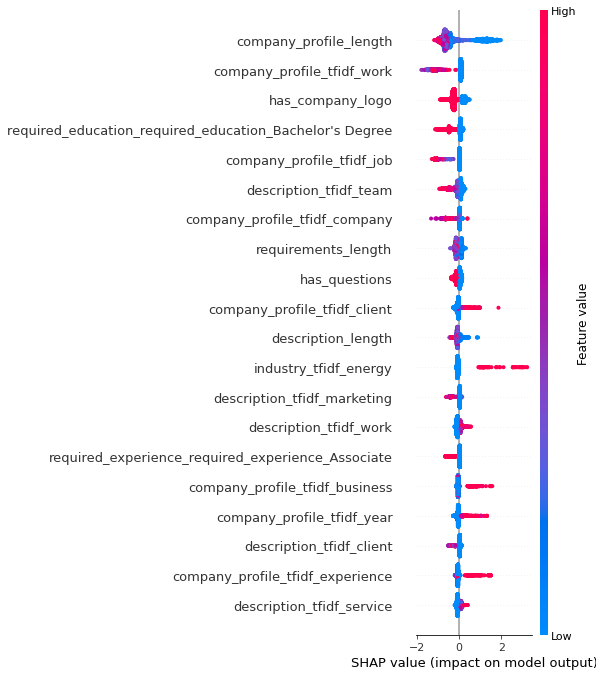


=== Top 10 Most Important Features ===
                                                Feature  Importance
                                 company_profile_length       0.706
                             company_profile_tfidf_work       0.383
                                       has_company_logo       0.269
required_education_required_education_Bachelor's Degree       0.191
                              company_profile_tfidf_job       0.182
                                 description_tfidf_team       0.154
                          company_profile_tfidf_company       0.151
                                    requirements_length       0.114
                                          has_questions       0.097
                           company_profile_tfidf_client       0.093

=== Feature Importance Percentages ===
                                                Feature  Percentage
                                 company_profile_length      14.52%
                             company

<Figure size 432x288 with 0 Axes>

In [3]:
## Load Model and Data
model = joblib.load('models/xgboost_model.joblib')
X_test = pd.read_pickle('data/X_test.pkl')
y_test = pd.read_pickle('data/y_test.pkl')
feature_names = X_test.columns.tolist()

class ShapAnalyzer:
    def __init__(self, model, data, feature_names):
        self.model = model
        self.data = data
        self.feature_names = feature_names
        self.explainer = shap.TreeExplainer(model)

    def get_shap_values(self):
        """Calculate SHAP values for the dataset"""
        shap_values = self.explainer.shap_values(self.data)
        if isinstance(shap_values, list):
            return shap_values[1]
        return shap_values

    def plot_feature_importance(self):
        """Plot global feature importance using SHAP values"""
        plt.figure(figsize=(15, 10))
        shap_values = self.get_shap_values()
        shap.summary_plot(shap_values, self.data, feature_names=self.feature_names)
        plt.tight_layout()
        
    def plot_feature_dependence(self, feature_name):
        """Plot dependence plot for a specific feature"""
        plt.figure(figsize=(12, 8))
        shap_values = self.get_shap_values()
        shap.dependence_plot(
            feature_name, 
            shap_values, 
            self.data,
            feature_names=self.feature_names
        )
        plt.tight_layout()

## Analysis Execution and Results Display
print("=== SHAP Analysis for Fraud Detection Model ===\n")

# Initialize SHAP analyzer
shap_analyzer = ShapAnalyzer(model, X_test, feature_names)

# Generate and display SHAP values
print("Global Feature Importance Plot:")
shap_analyzer.plot_feature_importance()

# Calculate feature importance
shap_values = shap_analyzer.get_shap_values()
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(shap_values).mean(0)
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

print("\n=== Top 10 Most Important Features ===")
print(feature_importance.head(10).to_string(index=False))

# Calculate and display feature importance percentages
total_importance = feature_importance['Importance'].sum()
feature_importance['Percentage'] = (feature_importance['Importance'] / total_importance * 100)

print("\n=== Feature Importance Percentages ===")
print(feature_importance.head(10)[['Feature', 'Percentage']].to_string(
    index=False, 
    float_format=lambda x: '{:.2f}%'.format(x)
))


# Additional Analysis
print("\n=== Feature Impact Analysis ===")

# Calculate positive and negative impacts
positive_impact = pd.DataFrame({
    'Feature': feature_names,
    'Positive_Impact': np.where(shap_values > 0, shap_values, 0).mean(0)
})
negative_impact = pd.DataFrame({
    'Feature': feature_names,
    'Negative_Impact': np.abs(np.where(shap_values < 0, shap_values, 0)).mean(0)
})

impact_analysis = pd.merge(positive_impact, negative_impact, on='Feature')
impact_analysis = impact_analysis.sort_values('Positive_Impact', ascending=False)

print("\nTop 5 Features with Strongest Positive Impact:")
print(impact_analysis.head()[['Feature', 'Positive_Impact']].to_string(index=False))

print("\nTop 5 Features with Strongest Negative Impact:")
impact_analysis_neg = impact_analysis.sort_values('Negative_Impact', ascending=False)
print(impact_analysis_neg.head()[['Feature', 'Negative_Impact']].to_string(index=False))

# Display summary statistics
print("\n=== Summary Statistics ===")
print(f"Total features analyzed: {len(feature_names)}")
print(f"Average feature importance: {feature_importance['Importance'].mean():.4f}")
print(f"Median feature importance: {feature_importance['Importance'].median():.4f}")
print(f"Standard deviation of importance: {feature_importance['Importance'].std():.4f}")
print(f"Features explaining 80% of impact: {len(feature_importance[feature_importance['Percentage'].cumsum() <= 80])}")
